# Aplicando la metodología CRISP-DM

El objetivo de este notebook es aplicar la metodología CRISP-DM (Cross-Industry Standard Process for Data Mining) para analizar y modelar los datos de posesiones de fútbol con el fin de predecir un KPI específico, en este caso 'xt_Medio_last'. A lo largo del notebook, se seguirán las fases de la metodología: comprensión del negocio, comprensión de los datos, preparación de los datos, modelado y evaluación.

Para ello, en primer lugar se han descargado datos de los partidos de las ultimas 5 temporadas de LaLiga desde la temporada 2019-2020 hasta la temporada 2024-2025. Los datos incluyen eventos de los partidos, alineaciones y estadísticas avanzadas de los equipos y jugadores como pueden ser informacion de los pases, tiros, regates, duelos y podemos obtener KPI avanzados como xT (Expected Threat) que es una métrica que cuantifica la amenaza ofensiva generada por las acciones de un equipo en el campo.
Gracias a esta medida podemos evaluar la efectividad de las posesiones y las decisiones tácticas de los equipos y se puede aplicar a los pases, centros y agrupar las posesiones para analizar la generación de oportunidades de gol distribuidas en diferentes zonas del campo.

Tras las descarga de datos, se han creado nuevos KPIs y features que se consideran relevantes para el análisis y modelado. Finalmente, se ha realizado un análisis exploratorio de los datos (EDA) para entender mejor las relaciones entre las variables y su impacto en el KPI objetivo.

# Obtención de los datos

## WHoscored
Para obtener los datos de eventos de los partidos hemos hecho uso de la libreria `soccerdata`para poder descargar los eventos de los partidos de LaLiga desde la temporada 2019-2020 hasta la temporada 2024-2025. 
Esta libreria nos permite descargar datos de diferentes ligas y competiciones de fútbol de manera sencilla y estructurada. Para poder saber los ids de los partidos de estos años, primero hemos descargado los calendarios de las temporadas y luego hemos extraido los ids de los partidos. Los calendarios se encuentran en la carpeta `data/calendars`. Luego, con los ids de los partidos, hemos descargado los eventos de cada partido y los hemos guardado en formato parquet en la carpeta `data/events/yyyy-yyyy`.

Por lo que ejecutando el fichero `main.py` se descargan los datos de eventos de los partidos, pero esto son datos raw y para construir el modelo es necesario realizar un par de transformaciones y crear nuevos KPIs.

Para ello hemos desarrollado un script `optimized_processing` en python que realiza las siguientes tareas:
    - Se encarga de iterar por cada uno de los archivos de eventos descargados.
    - reconstruct_carries
    - compute_xt_from_epv
    - annotate_pass_recipients_next_event
    - etiquetar_zonas
    - assign_possession_ids_by_period
    - procesar_partido_con_xt
      - assign_possession_ids_by_period
      - reconstruct_carries
      - compute_xt_from_epv
      - annotate_pass_recipients_next_event
      - etiquetar_zonas
      - 

```python

# Objetivo del experimento

### Pregunta de investigación
**En cuanto un equipo completa su salida de balón desde el tercio defensivo, ¿cuánta amenaza ofensiva (xT) terminará generando esa posesión en el tercio medio?**

Para este experimento vamos ha hacer uso de los datos de las temporadas 2022-2023 y 2023-2024 de LaLiga que estos datos se encuentran en la carpeta `processed_data/2022-2023.csv` y `processed_data/2023-2024.csv` respectivamente.

Estos son datos procesados a nivel de posesión y calculando el xT para cada posesion en cada zona del campo, pero para este estudio vamos a centrarnos en las posesiones que comienzan en el tercio defensivo y terminan en el tercio medio, y vamos a predecir la cantidad de xT generada en el tercio medio (`xt_Medio_last`) a partir de las características de la posesión.

Para descartar datos que no aportan valor al experimento, vamos a filtrar las posesiones que cumplen las siguientes condiciones:
- La posesión debe comenzar en el tercio defensivo (campo propio).
- La posesion en el tercio medio y ofensivo debe ser > 0 (esto asegura que la posesión ha llegado al tercio medio y ha generado alguna amenaza ofensiva).

La variable objetivo que queremos predecir es `xt_Medio_last`, es decir, el xT generado por la posesión en el tercio medio.




In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [ ]:

df_23_24 = pd.read_csv("processed_data/2023-2024.csv")
df_22_23 = pd.read_csv("processed_data/2022-2023.csv")

all_df = pd.concat([df_22_23, df_23_24], ignore_index=True)

defensive_start_zone = all_df[(all_df["tercio_start"] == "Defensivo") & (all_df["xt_Medio"] > 0) & (all_df["xt_Ofensivo"] > 0)& (all_df["xt_possession"] > 0)]

defensive_start_zone

,game_id,period,minute,second,expanded_minute,type,outcome_type,team_id,team,player_id,...,duels_lost_won_ratio,possession_duration,minute_bucket,home_goals_pos,away_goals_pos,score_state,score_diff_pos,goals_for_pos,goals_against_pos,scoreline_pos_match
23,1650559,FirstHalf,1,17.0,1,Pass,Successful,53,Athletic Club,78500.0,...,0.0,0.216667,0-15,0,0,0,0,0,0,0-0
24,1650559,FirstHalf,1,19.0,1,Pass,Successful,53,Athletic Club,255182.0,...,0.0,0.216667,0-15,0,0,0,0,0,0,0-0
104,1650559,FirstHalf,6,5.0,6,Pass,Successful,55,Valencia,401633.0,...,0.0,1.333333,0-15,0,0,0,0,0,0,0-0
105,1650559,FirstHalf,6,7.0,6,Pass,Successful,55,Valencia,400357.0,...,0.0,1.333333,0-15,0,0,0,0,0,0,0-0
119,1650559,FirstHalf,6,51.0,6,Pass,Successful,55,Valencia,401633.0,...,0.0,1.333333,0-15,0,0,0,0,0,0,0-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198135,1735000,SecondHalf,81,10.0,88,Carry,Successful,925,Granada,405310.0,...,0.0,0.450000,75-90,2,3,-1,-1,2,3,2-3
1198136,1735000,SecondHalf,81,12.0,88,Pass,Successful,925,Granada,405310.0,...,0.0,0.450000,75-90,2,3,-1,-1,2,3,2-3
1198211,1735000,SecondHalf,85,45.0,92,TakeOn,Successful,839,Villarreal,448041.0,...,0.0,0.250000,75-90,2,3,1,1,3,2,2-3
1198212,1735000,SecondHalf,85,45.0,92,Carry,Successful,839,Villarreal,448041.0,...,0.0,0.250000,75-90,2,3,1,1,3,2,2-3


In [ ]:
first_cols = [
    'game_id', 'period', 'team', 'team_id', 'rival_team', 'rival_team_id',
    'minute', 'second', 'expanded_minute', 'home_team_id', 'away_team_id',
    'possession_id_team', 'tercio_start', 'intermedio_start',
    'possession_start_min', 'minute_bucket', 'scoreline_event_match'
]

event_numeric_cols = [
    'num_passes', 'num_carries', 'successful_passes', 'total_progressive_dx',
    'duels_won', 'duels_lost', 'duels_lost_won_ratio', 'possession_duration',
    'distance_xy', 'pass_angle', 'verticality', 'progressive_dx',
    'pct_passes_completed'
]


kpi_cols = [
    'xt_Defensivo', 'xt_Medio', 'xt_Ofensivo',
    'xt_possession', 'xt_quantile'
]

agg_dict = {}


for col in first_cols:
    if col in defensive_start_zone.columns:
        agg_dict[col] = 'first'


agg_funcs = ['sum', 'mean', 'max', 'min', 'std']
for col in event_numeric_cols + kpi_cols:
    if col in defensive_start_zone.columns:
        agg_dict[col] = agg_funcs


agg_dict['xt_Medio'] = 'last'


df_possessions = defensive_start_zone.groupby(['possession_id', 'team_id']).agg(agg_dict).reset_index()


df_possessions.columns = ['_'.join(filter(None, col)).strip('_') for col in df_possessions.columns.values]


drop_cols = [col for col in df_possessions.columns if 'player' in col or 'player_id' in col or 'event_id' in col]
df_possessions.drop(columns=drop_cols, inplace=True, errors='ignore')


print(df_possessions.head())
print(df_possessions.info())



   possession_id  team_id  game_id_first period_first       team_first  \
0              2       51        1650888    FirstHalf         Mallorca   
1              2       52        1734804    FirstHalf      Real Madrid   
2              2       53        1650579    FirstHalf    Athletic Club   
3              2       55        1650593    FirstHalf         Valencia   
4              2       58        1650604    FirstHalf  Real Valladolid   

   team_id_first rival_team_first  rival_team_id_first  minute_first  \
0             51            Cadiz                 1354             0   
1             52         Atletico                   63             0   
2             53         Espanyol                   70             0   
3             55   Rayo Vallecano                   64             0   
4             58            Cadiz                 1354             0   

   second_first  ...  xt_Ofensivo_sum  xt_Ofensivo_mean  xt_Ofensivo_max  \
0           0.0  ...           0.0938         

## Exploratory Data Analysis (EDA)
Realizamos un anális exploratorio de los datos para entender su estructura, identificar patrones y detectar posibles problemas de calidad de datos.

El objetivo de este análisis es:

1. **Explorar el target (`xt_Medio_last`)**  
   - Revisar su distribución (media, mediana, rango, asimetría, curtosis).  
   - Detectar si es necesario aplicar transformaciones (log, boxcox) para estabilizar la varianza.  
   - Visualizar posibles outliers mediante histogramas y boxplots.  

2. **Examinar las variables numéricas agregadas por posesión**  
   - Distribuciones individuales para entender su escala y comportamiento.  
   - Identificar qué variables se correlacionan más con el target.  
   - Visualizar boxplots de las variables más relevantes.  

3. **Relaciones entre features y target**  
   - Graficar dispersión (scatter + recta de regresión) de las variables más correlacionadas frente al `xt_Medio_last`.  

4. **Correlaciones y multicolinealidad**  
   - Analizar la matriz de correlación entre las top features.  
   - Calcular el **VIF (Variance Inflation Factor)** para comprobar redundancias y posibles problemas de multicolinealidad que puedan afectar a modelos lineales.  

Este análisis permitirá:
- Detectar outliers y sesgos.  
- Entender qué variables tienen mayor capacidad predictiva.  
- Decidir si es necesario transformar, escalar o descartar alguna variable antes del modelado.

Estadísticos básicos de xt_Medio_last:
count    5.959000e+03
mean     9.677093e-03
std      9.095928e-03
min      8.673617e-19
25%      3.900000e-03
50%      7.300000e-03
75%      1.260000e-02
max      2.069000e-01
Name: xt_Medio_last, dtype: float64
Asimetría: 3.9967527095416626
Curtosis: 47.714584912648824


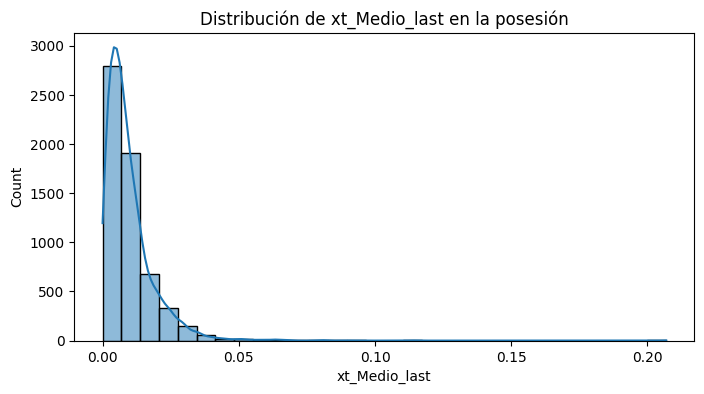

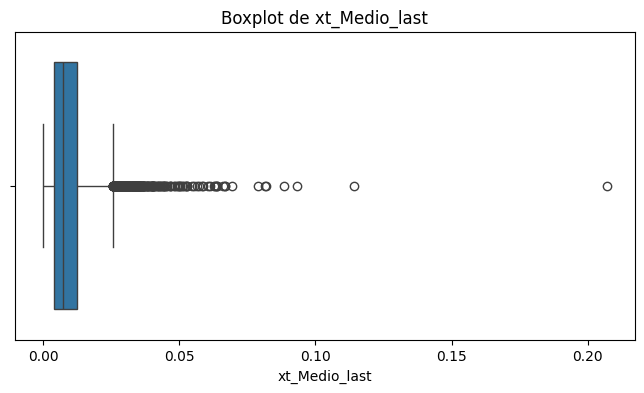

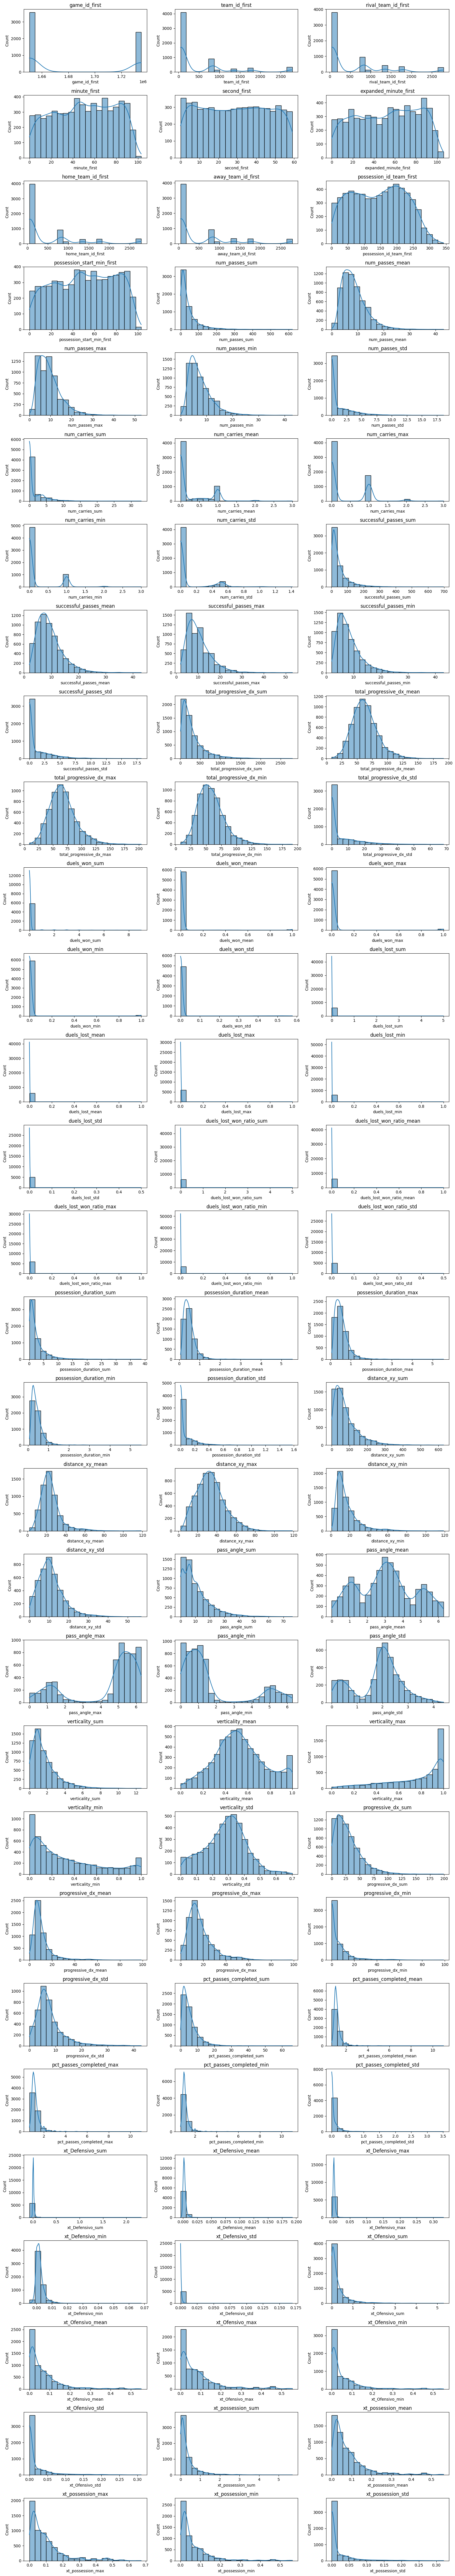

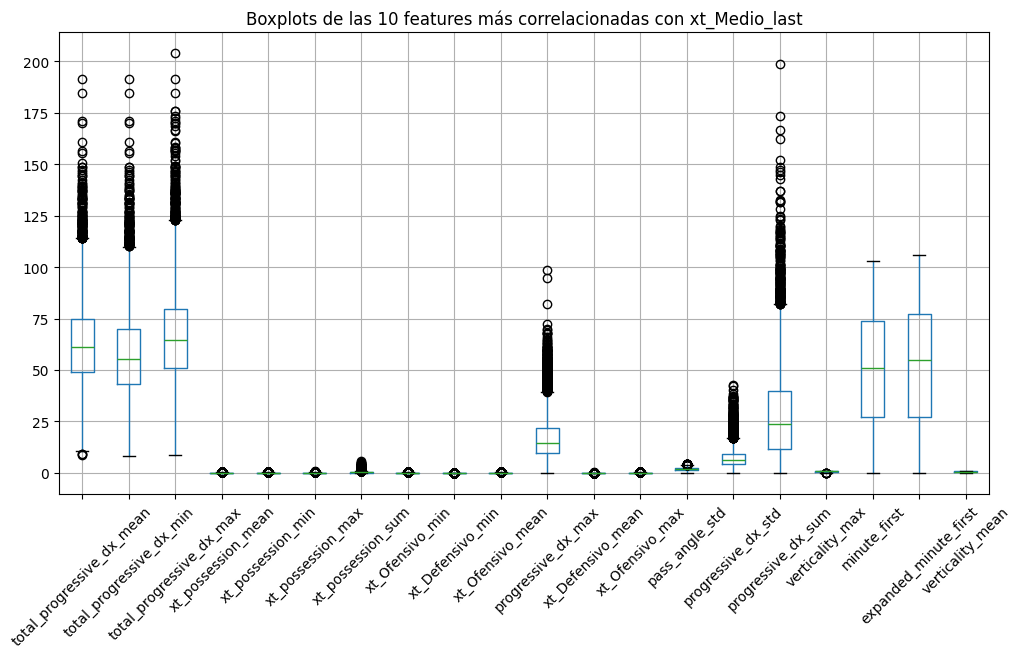

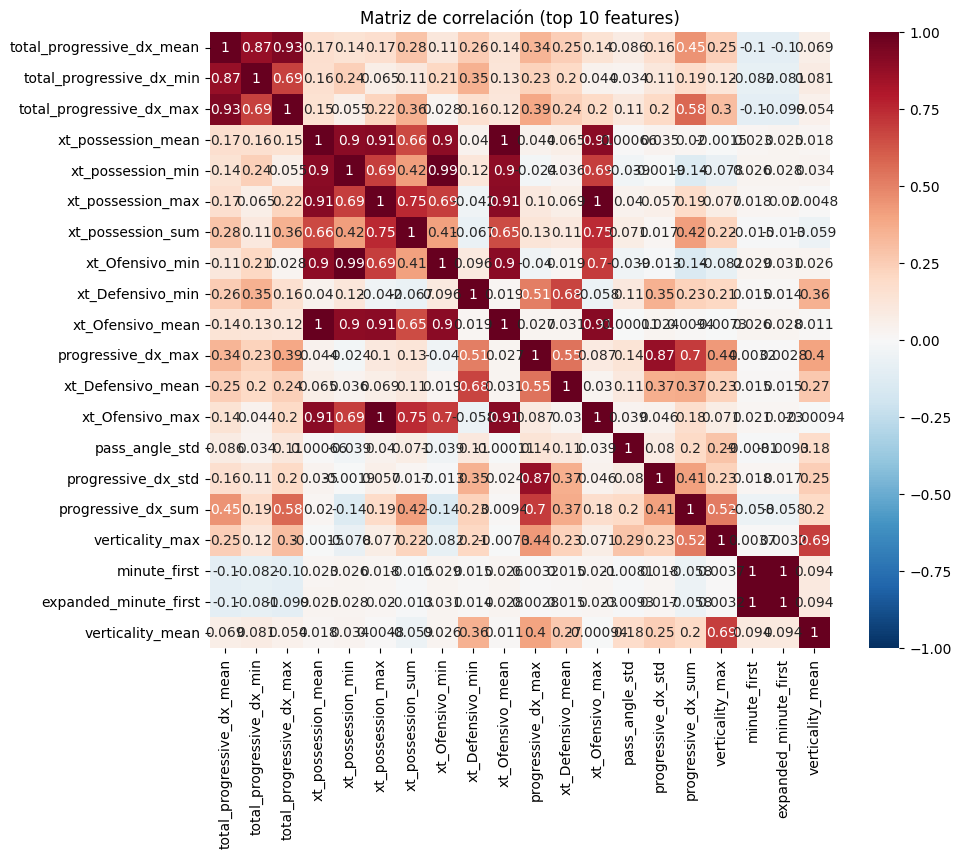

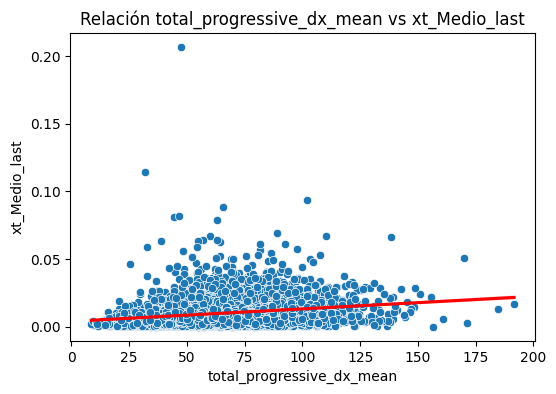

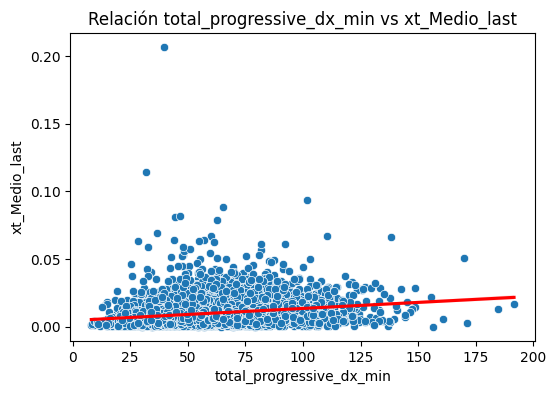

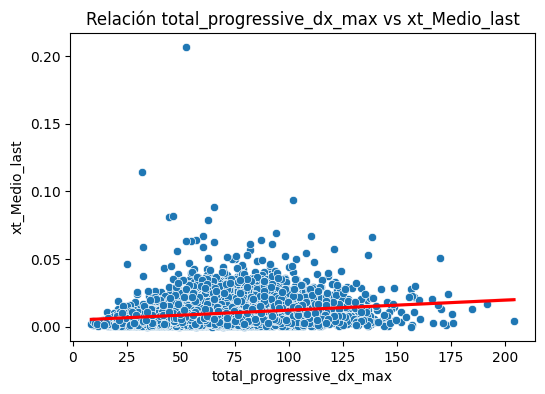

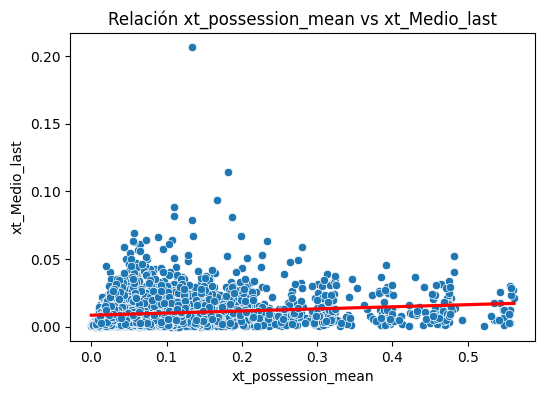

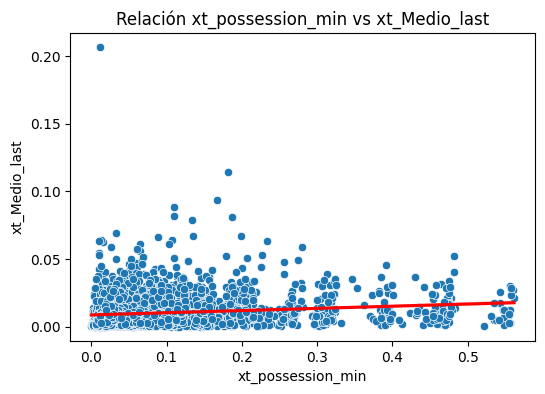

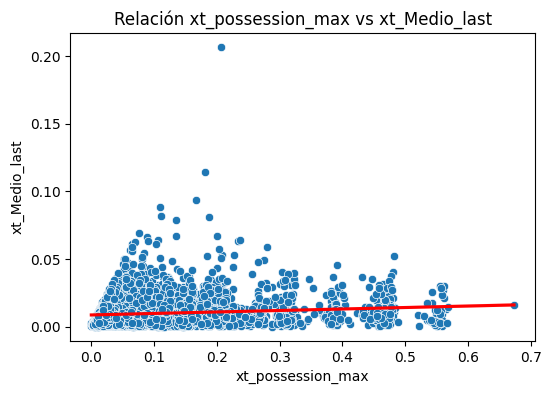

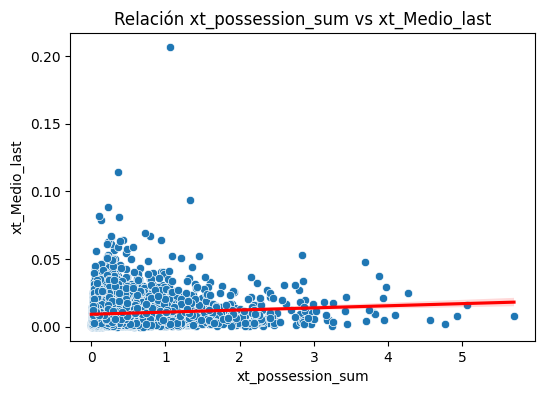

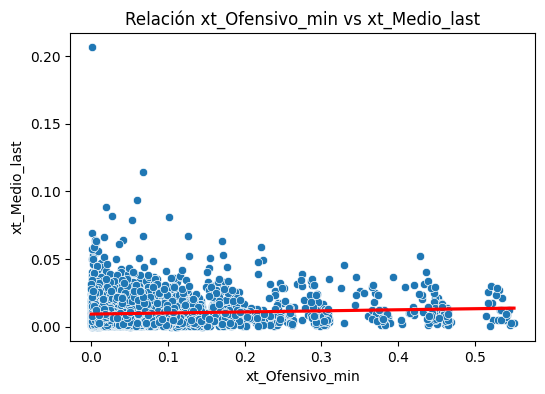

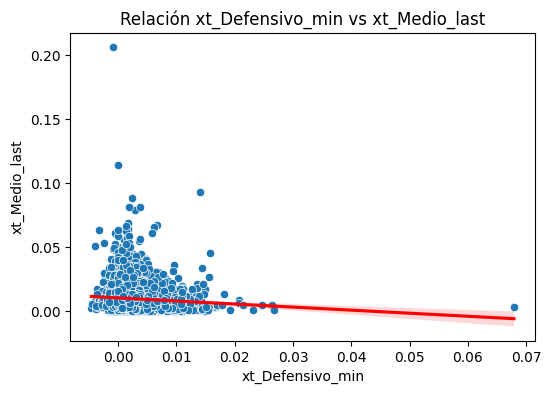

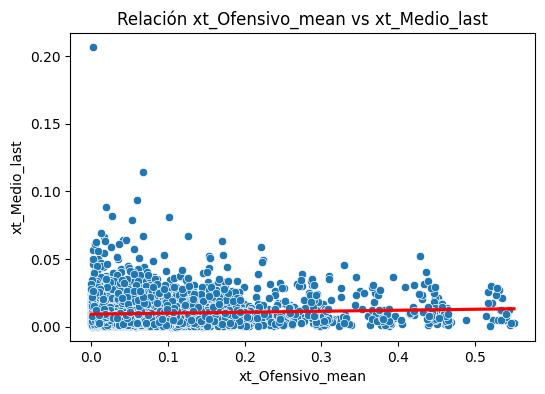

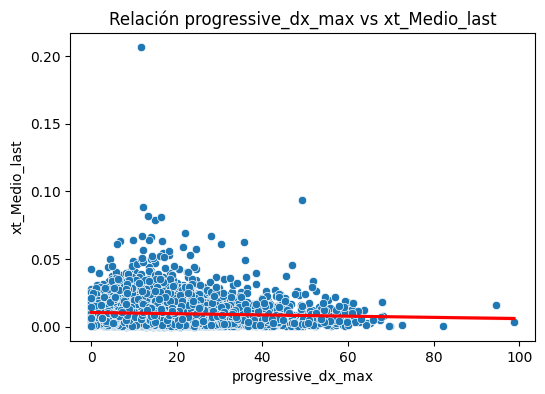

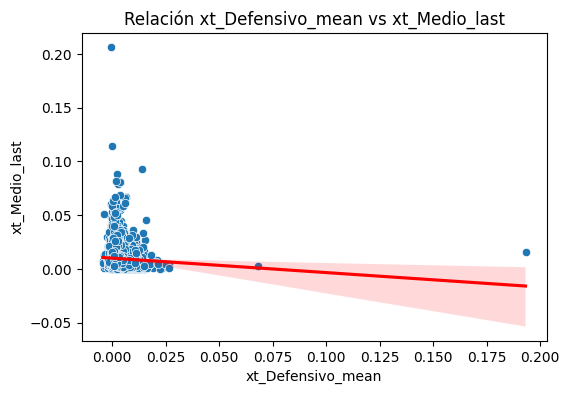

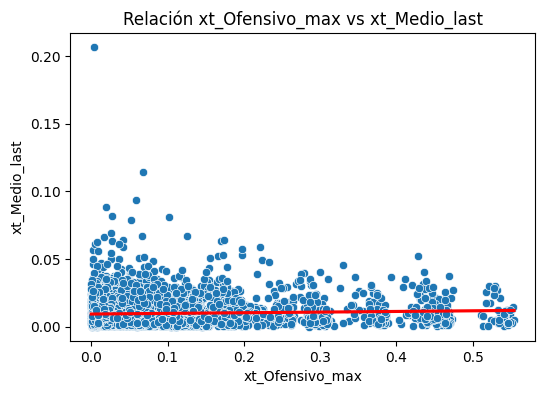

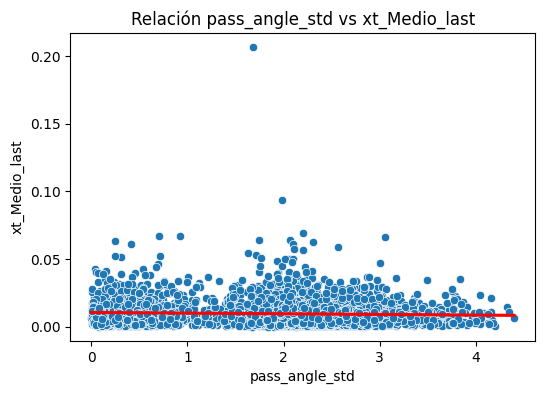

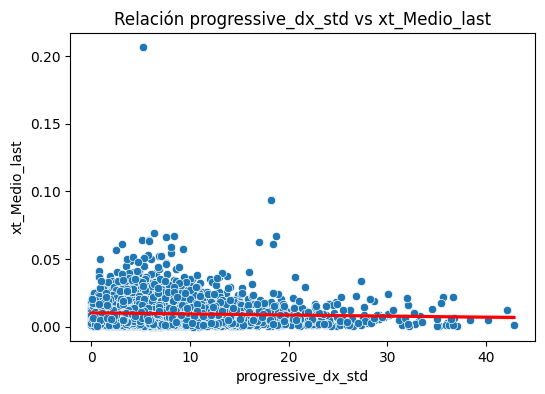

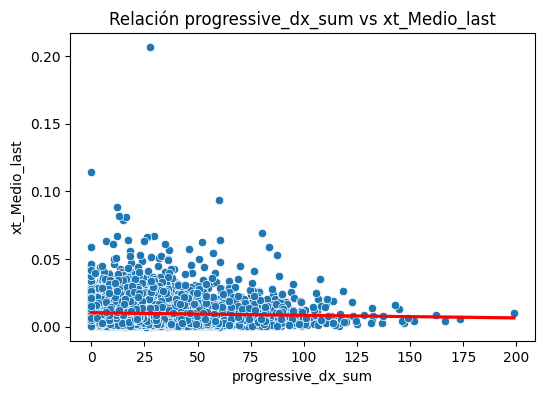

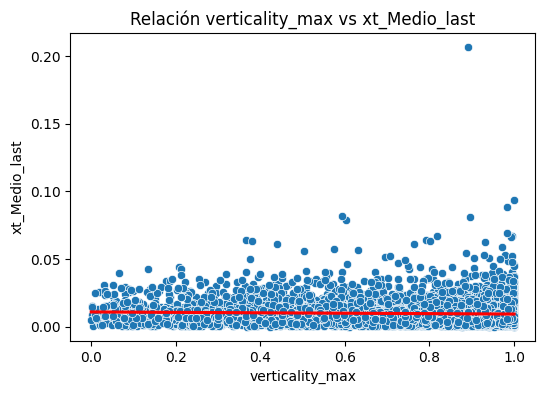

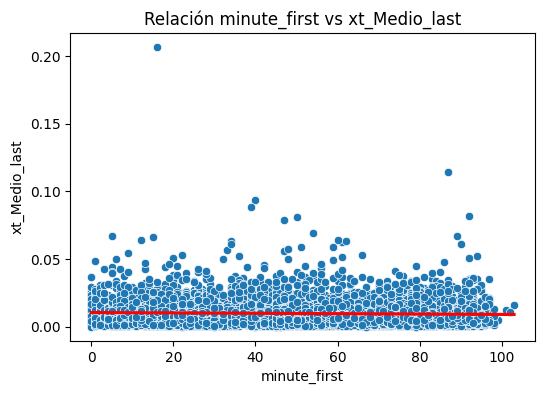

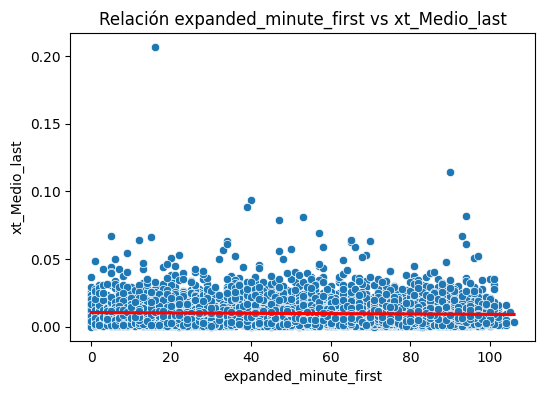

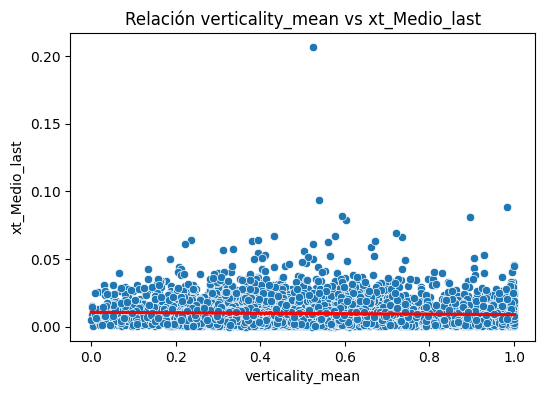

                      feature          VIF
3          xt_possession_mean  3270.062200
9            xt_Ofensivo_mean  2830.205455
5           xt_possession_max  1505.198233
12            xt_Ofensivo_max  1345.202221
17               minute_first  1137.247585
18      expanded_minute_first  1112.876125
4           xt_possession_min   860.845789
7             xt_Ofensivo_min   744.292242
0   total_progressive_dx_mean   318.992173
2    total_progressive_dx_max   144.030460
1    total_progressive_dx_min    70.269548
10         progressive_dx_max    44.063971
16            verticality_max    30.334485
19           verticality_mean    20.039342
14         progressive_dx_std    17.992349
15         progressive_dx_sum    16.382548
6           xt_possession_sum     7.762771
13             pass_angle_std     5.397103
11          xt_Defensivo_mean     3.697020
8            xt_Defensivo_min     3.523387


In [ ]:


var_prediction = 'xt_Medio_last'  # Cambiar si se quiere predecir otro KPI de xT

# 1. Target
print('Estadísticos básicos de {}:'.format(var_prediction))
print(df_possessions[var_prediction].describe())
print('Asimetría:', skew(df_possessions[var_prediction].dropna()))
print('Curtosis:', kurtosis(df_possessions[var_prediction].dropna()))

plt.figure(figsize=(8,4))
sns.histplot(df_possessions[var_prediction], bins=30, kde=True)
plt.title(f'Distribución de {var_prediction} en la posesión')
plt.xlabel(var_prediction)
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df_possessions[var_prediction])
plt.title(f'Boxplot de {var_prediction}')
plt.show()

# 2. Variables numéricas agregadas
numeric_cols = df_possessions.select_dtypes(include=[np.number]).columns.drop([var_prediction,'possession_id','team_id'])
ncols = 3
nrows = int(np.ceil(len(numeric_cols)/ncols))
plt.figure(figsize=(16, nrows*3))
for i, col in enumerate(numeric_cols):
    plt.subplot(nrows, ncols, i+1)
    sns.histplot(df_possessions[col], bins=20, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Boxplots de las principales features (solo numéricas y existentes)
# Selección robusta de las X features más correlacionadas (elegimos 20 pero se puede cambiar)
corr_with_target = df_possessions.corr(numeric_only=True)[var_prediction].abs().sort_values(ascending=False)
top_features = [col for col in corr_with_target.index if col != var_prediction][:20]
# Filtrado para asegurar que todas existen y son numéricas
existing_numeric_cols = [col for col in top_features if col in df_possessions.columns and pd.api.types.is_numeric_dtype(df_possessions[col])]

plt.figure(figsize=(12, 6))
df_possessions.boxplot(column=existing_numeric_cols)
plt.title(f'Boxplots de las 10 features más correlacionadas con {var_prediction}')
plt.xticks(rotation=45)
plt.show()

# 3. Correlaciones avanzadas
corr_matrix = df_possessions[existing_numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Matriz de correlación (top 10 features)')
plt.show()

# 4. Relación features principales vs target
for col in existing_numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_possessions[col], y=df_possessions[var_prediction])
    sns.regplot(x=df_possessions[col], y=df_possessions[var_prediction], scatter=False, color='red')
    plt.title(f'Relación {col} vs {var_prediction}')
    plt.show()

# 5. Multicolinealidad (VIF)
X_temp = df_possessions[existing_numeric_cols].dropna()
vif_data = pd.DataFrame()
vif_data['feature'] = X_temp.columns
vif_data['VIF'] = [variance_inflation_factor(X_temp.values, i) for i in range(len(X_temp.columns))]
print(vif_data.sort_values('VIF', ascending=False))



# Modelado
Elección y entrenamiento de modelos adecuados (clasificación, regresión) que dependerá del problema en cuestión. Es importante probar con distintos métodos de la misma clase y hacer ajuste de hiperparámetros (GridSearch).

# 1 Experimento
Nuestro objetivo es predecir el KPI 'xt_Medio_last'. Para ello, hemos creamos un pipleline de procesamiento de datos y realizamos un GridSearch para encontrar el mejor modelo y sus hiperparámetros.


In [11]:
X = df_possessions[top_features].copy()  # top_features viene del EDA anterior
y = df_possessions[var_prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


degree = [1, 2, 3]
alpha = [1e-4, 1e-2, 0.1, 1, 10, 100]

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())  # se sobrescribe en el grid
])

param_grid = [
    # Regresión polinómica
    {
        'model': [make_pipeline(PolynomialFeatures(), LinearRegression())],
        'model__polynomialfeatures__degree': degree,
    },
    # Ridge
    {
        'model': [Ridge()],
        'model__alpha': alpha,
    },
    # Lasso
    {
        'model': [Lasso(max_iter=10000)],
        'model__alpha': alpha,
    },
    # ElasticNet
    {
        'model': [ElasticNet(max_iter=10000)],
        'model__alpha': alpha,
        'model__l1_ratio': [0.1, 0.5, 0.9],
    },
    # Random Forest
    {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [None, 3, 5, 10],
    },
    # Gradient Boosting
    {
        'model': [GradientBoostingRegressor(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.01, 0.1, 0.3],
    },
    # AdaBoost
    {
        'model': [AdaBoostRegressor(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1.0],
    },
    # KNN
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [3, 5, 7],
    },
    # SVR
    {
        'model': [SVR()],
        'model__degree': degree,
        'model__gamma': ['scale', 'auto'],
        'model__C': alpha,
        'model__epsilon': [1e-6, 1e-3, 1e-2, 1e-1, 1],
    },
    # Regresión log-exp
    {
        'model': [
            TransformedTargetRegressor(
                regressor=LinearRegression(),
                func=np.log1p,  # log(1+x) para evitar problemas con log(0)
                inverse_func=np.expm1
            )
        ],
    },
]


In [12]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'r2'  # o 'neg_mean_squared_error'

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)
grid.fit(X, y)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=1; total time=   0.0s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=1; total time=   0.0s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=1; total time=   0.0s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=1; total time=   0.0s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__

/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.444e-05, tolerance: 4.161e-05
  model = cd_fast.enet_coordinate_descent(


[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.1; total time=   1.6s


/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.311e-05, tolerance: 3.907e-05
  model = cd_fast.enet_coordinate_descent(


[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.5; total time=   1.5s


/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.838e-05, tolerance: 3.693e-05
  model = cd_fast.enet_coordinate_descent(


[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.1; total time=   1.8s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.1; total time=   1.5s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=3; total time=   4.7s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=3; total time=   4.7s
[CV] END model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]), model__polynomialfeatures__degree=3; total time=   4.9s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.01, model__l1_ratio=0.1; total time=   0.0s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.01, model__l1_ratio=0.1; total time=   0.0s
[CV] END 

/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.973e-05, tolerance: 3.995e-05
  model = cd_fast.enet_coordinate_descent(


[CV] END model=ElasticNet(max_iter=10000), model__alpha=100, model__l1_ratio=0.9; total time=   0.0s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.9; total time=   0.5s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.9; total time=   0.4s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.5; total time=   1.1s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.5; total time=   1.0s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.9; total time=   0.7s
[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.9; total time=   0.2s


/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.446e-05, tolerance: 4.161e-05
  model = cd_fast.enet_coordinate_descent(


[CV] END model=ElasticNet(max_iter=10000), model__alpha=0.0001, model__l1_ratio=0.5; total time=   0.8s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=3, model__n_estimators=100; total time=   1.6s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=3, model__n_estimators=100; total time=   1.5s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=3, model__n_estimators=100; total time=   1.4s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=None, model__n_estimators=100; total time=   6.8s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=None, model__n_estimators=100; total time=   6.9s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=None, model__n_estimators=100; total time=   6.9s
[CV] END model=RandomForestRegressor(random_state=42), model__max_depth=3, model__n_estimators=100; total time=   1.5s
[CV] END model=RandomForestRegressor(random_state=42),

/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.001, model__gamma=auto; total time=   0.8s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.001, model__gamma=auto; total time=   0.8s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.001, model__gamma=scale; total time=   0.8s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.001, model__gamma=scale; total time=   0.8s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=1e-06, model__gamma=auto; total time=   1.7s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=1e-06, model__gamma=auto; total time=   1.8s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.01, model__gamma=scale; total time=   0.1s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=0.01, model__gamma=scale; total time=   0.1s
[CV] END model=SVR(), model__C=0.1, model__degree=2, model__epsilon=1e-06, model__gamma=auto; 

,estimator,Pipeline(step...egression())])
,param_grid,"[{'model': [Pipeline(step...egression())])], 'model__polynomialfeatures__degree': [1, 2, ...]}, {'model': [Ridge()], 'model__alpha': [0.0001, 0.01, ...]}, ...]"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [13]:
print(f"\nMejor modelo: {grid.best_estimator_}")
print(f"Mejores hiperparámetros: {grid.best_params_}")
print(f"Mejor score de CV (R2): {grid.best_score_:.4f}")

best_model = grid.best_estimator_





Mejor modelo: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])
Mejores hiperparámetros: {'model': TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())}
Mejor score de CV (R2): 0.8253


In [14]:


y_pred_test = best_model.predict(X_test)
print("R2 test:", r2_score(y_test, y_pred_test))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE test: {rmse_test:.4f}")



R2 test: 0.8398464120913898
RMSE test: 0.0037


## Análisis del experimento 1

En primer lugar, para realizar el GridSearch se ha realizado un KfoldAleatorio con 5 splits con shuffle(que significa que los datos se barajan aleatoriamente antes de dividirlos en los diferentes folds) y random_state=42 para asegurar la reproducibilidad de los resultados.

El mejor modelo encontrado ha sido TransformedTargetRegressor() (log1p + LinearRegression) con un score de (R2): 0.8253.

**Crítica metodológica**
Este valor de score es bastante alto pero hay un pequeño problema, esta validación mezcla posesiones del mismo partido entre train y validacion, lo que puede llevar a un sobreajuste y a una evaluación poco realista del rendimiento del modelo debido a que las posesiones del mismo partido pueden tener características similares. Por lo que no es un resultado optimista ni fiable.

**Conclusión**
- La validación con KFold aleatorio no es adecuada para este tipo de datos ya que hay que analizar las posesion de un mismo partido de forma conjunta (esto se debe a que cada equipo tiene su propia identidad y estilo de juego, y las posesiones dentro de un mismo partido pueden estar influenciadas por factores específicos del encuentro, como la estrategia del equipo, las condiciones del partido, etc. Estas posesiones en base a las circusntancias de juego y del rival pueden ser diferentes de un partido a otro).
- Por lo tanto, para este problema no es adecuado mezclar posesiones de diferentes partidos en los conjuntos de entrenamiento y validación.


## Experimento 2

Una vez visto el problema anterior realizamos un segundo experimento donde se ha realizado un GroupKFold con 5 splits, donde el grupo es el 'match_id' (identificador único de cada partido). Esto asegura que todas las posesiones de un mismo partido estén en el mismo fold, evitando la fuga de datos entre entrenamiento y validación.


In [27]:

def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include=['float64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='float')  # float32
    for c in df.select_dtypes(include=['int64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='integer')
    return df

df_possessions = downcast_df(df_possessions)


var_prediction = 'xt_Medio_last'
MATCH_COL = 'game_id_first' if 'game_id_first' in df_possessions.columns else 'game_id'

id_like_cols = [c for c in ['possession_id','team_id', MATCH_COL,
                            'home_team_id_first','away_team_id_first','possession_id_team_first']
                if c in df_possessions.columns]

numeric_cols = df_possessions.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in ([var_prediction] + id_like_cols)]

X = df_possessions[feature_cols].astype('float32').copy()
y = df_possessions[var_prediction].astype('float32').to_numpy()
match_id = df_possessions[MATCH_COL].to_numpy()

#  Split TEST por partido (sin mezclar)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=match_id))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = match_id[train_idx]

# Modelos con pipelines específicos (sin scaler global)


pipe_lin = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('scaler', StandardScaler()),
                        ('model', LinearRegression())])

pipe_knn = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('scaler', StandardScaler()),
                        ('model', KNeighborsRegressor())])

pipe_poly = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('poly', PolynomialFeatures(include_bias=False)),
                        ('scaler', StandardScaler()),
                        ('model', LinearRegression())])

pipe_tree = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('model', RandomForestRegressor(random_state=42))])  # sin scaler

pipe_gb = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                    ('model', GradientBoostingRegressor(random_state=42))])

pipe_ada = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('model', AdaBoostRegressor(random_state=42))])

pipe_ttr = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('scaler', StandardScaler()),
                        ('model', TransformedTargetRegressor(
                            regressor=LinearRegression(),
                            func=np.log1p, inverse_func=np.expm1
                        ))])

# Grid
degree = [1, 2]
alpha = [1e-3, 1e-2, 0.1, 1]

param_grid = [
    {'pipeline': [pipe_poly],
        'pipeline__poly__degree': degree},

    {'pipeline': [pipe_lin],
        'pipeline__model': [Ridge(random_state=42)],
        'pipeline__model__alpha': alpha},

    {'pipeline': [pipe_lin],
        'pipeline__model': [Lasso(max_iter=10000, random_state=42)],
        'pipeline__model__alpha': alpha},

    {'pipeline': [pipe_lin],
        'pipeline__model': [ElasticNet(max_iter=10000, random_state=42)],
        'pipeline__model__alpha': [1e-3, 1e-2, 0.1],
        'pipeline__model__l1_ratio': [0.3, 0.7]},

    {'pipeline': [pipe_tree],
        'pipeline__model__n_estimators': [200],
        'pipeline__model__max_depth': [None, 10],
        'pipeline__model__min_samples_leaf': [1, 3]},

    {'pipeline': [pipe_gb],
        'pipeline__model__n_estimators': [100],
        'pipeline__model__max_depth': [3],
        'pipeline__model__learning_rate': [0.05, 0.1]},

    {'pipeline': [pipe_ada],
        'pipeline__model__n_estimators': [100],
        'pipeline__model__learning_rate': [0.1, 1.0]},

    {'pipeline': [pipe_ttr]},
]

# GridSearchCV

cv = GroupKFold(n_splits=5)

def count_candidates(pg):
    tot = 0
    for g in pg:
        m = 1
        for v in g.values():
            m *= len(v) if isinstance(v, list) else 1
        tot += m
    return tot

n_cand = count_candidates(param_grid)
print(f"Candidatos: {n_cand} | Fits ≈ {n_cand * 5}")

grid = GridSearchCV(
    estimator=Pipeline([('pipeline', pipe_lin)]),
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=2,
    pre_dispatch='2*n_jobs',
    verbose=1,
    refit=True,
    return_train_score=False,
    error_score='raise'
)

grid.fit(X_train, y_train, groups=groups_train)




Candidatos: 25 | Fits ≈ 125
Fitting 5 folds for each of 25 candidates, totalling 125 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/Users/catalin/Library/Caches/pypoetry/virtualenvs/optatacticsprofiler-oiP5ydwD-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
0.00s - Debugger warning: It seems that frozen modules are being

,estimator,Pipeline(step...ession())]))])
,param_grid,"[{'pipeline': [Pipeline(step...egression())])], 'pipeline__poly__degree': [1, 2]}, {'pipeline': [Pipeline(step...egression())])], 'pipeline__model': [Ridge(random_state=42)], 'pipeline__model__alpha': [0.001, 0.01, ...]}, ...]"
,scoring,'r2'
,n_jobs,2
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,steps,"[('imputer', ...), ('scaler', ...), ...]"


In [28]:
print("\nMejor modelo:", grid.best_estimator_)
print("Mejores hiperparámetros:", grid.best_params_)
print(f"Mejor score CV (r2): {grid.best_score_:.4f}")

best_pipe = grid.best_estimator_.named_steps['pipeline']


y_pred_test = best_pipe.predict(X_test)
print(f"R2 test: {r2_score(y_test, y_pred_test):.4f}")
# For compatibility with older scikit-learn, compute RMSE manually
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"RMSE test: {rmse:.4f}")


Mejor modelo: Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler()),
                                 ('model', Ridge(alpha=1, random_state=42))]))])
Mejores hiperparámetros: {'pipeline': Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', LinearRegression())]), 'pipeline__model': Ridge(random_state=42), 'pipeline__model__alpha': 1}
Mejor score CV (r2): 0.8013
R2 test: 0.8229
RMSE test: 0.0036


## Análisis del experimento 2

En este segundo experimento, al utilizar GroupKFold con 'match_id' como grupo, hemos asegurado que todas las posesiones de un mismo partido se mantengan juntas en el mismo fold durante la validación cruzada. Esto es crucial para evitar la fuga de datos y obtener una evaluación más realista del rendimiento del modelo.

El mejor modelo es Ridge con alfa=1.0 con un score de (R2): 0.8013 y R2 en test de 0.8229.

**Crítica metodológica**
El valor de R2 obtenido es ligeramente inferior al del primer experimento, pero es un resultado más fiable y realista ya que hemos evitado la fuga de datos entre entrenamiento y validación. Esto indica que el modelo tiene una buena capacidad predictiva sin sobreajustarse a las posesiones de partidos específicos.

**Conclusión**
- El modelo Ridge es más robusto y generaliza mejor a partidos ó posesiones no vistas durante el entrenamiento.
- La validación con GroupKFold es más adecuada para este tipo de datos ya que mantiene la integridad de las posesiones dentro de cada partido.

- Podemos decir que es un bien modelo y mantiene el rendimineto en todos los folds y generaliza mejor en partidos/posesiones que no se han visto en el entrenamiento (en un caso de uso real, el modelo se enfrentaría a partidos y posesiones no vistas previamente) y podemos decir que es un buen modelo para predecir el KPI 'xt_Medio_last' en posesiones que comienzan en el tercio defensivo y terminan en el tercio medio.


# 2. Análisis de residuos y visualización
Una vez seleccionado el mejor modelo (Ridge con alfa=1.0), es importante analizar los residuos para evaluar la calidad del ajuste y detectar posibles problemas sobre el test (partidos no vistos).

1. **Ridge: xT real vs. predicho (Test)**
   - La nube de puntos debe estar cerca de la línea diagonal roja (predicciones perfectas). Se observa que hay una buena capacidad de predicción, aunque hay cierta dispersión en valores altos de xT.
   - Es normal que haya más dispersión en valores altos de xT, ya que son menos frecuentes y más difíciles de predecir con precisión.
   - El fútbol como cualquier deporte muchas veces es impredecible y depende de la calidad y creatividad de los jugadores en el campo, por lo que siempre habrá cierto grado de incertidumbre en las predicciones.
2. **Distribución de residuos**
    - Los residuos (diferencia entre el valor real y el predicho) deben estar centrados alrededor de cero y seguir una distribución normal.
    - Observamos que esto se cumple en general lo que significa que el modelo no tiene un sesgo sistemático, es decir, no tiende a sobrestimar o subestimar consistentemente el xT.
    - Sin embargo, hay algunos outliers (residuos muy grandes) que indican posesiones con xT muy poco frecuente.

3. **Residuos vs predicho (para ver sesgos)**
   - La nube de residuos se distribuye alrededor de 0 sin patrones evidentes, lo que confirmar errores aleatorios.
   - Se observa mayor dispersión para posesiones con valores de xT más altos, lo cual es esperable dada la baja frecuencia de dichas posesiones.


**Conclusión del análisis de residuos**
   - El modelo Ridge generalizar bien los datos de test (datos no vistos en el entrenamiento).
   - Podemos lograr un equilibreo entre la simpricidad, interpretabilidad y capacidad predictiva.
   - Los errores son bajos y distribuidos aleatoriamente, sin sesgos evidentes.

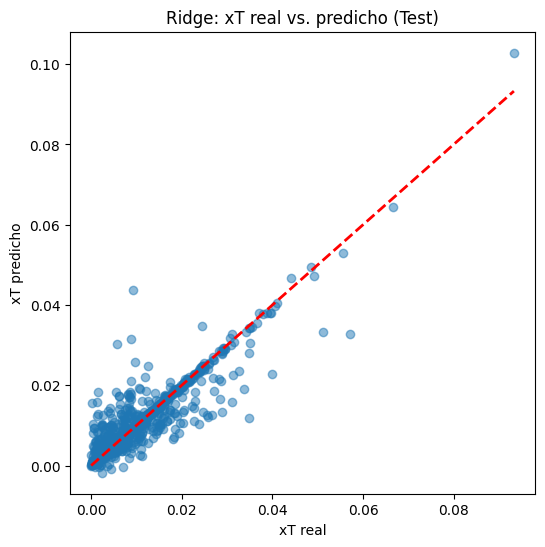

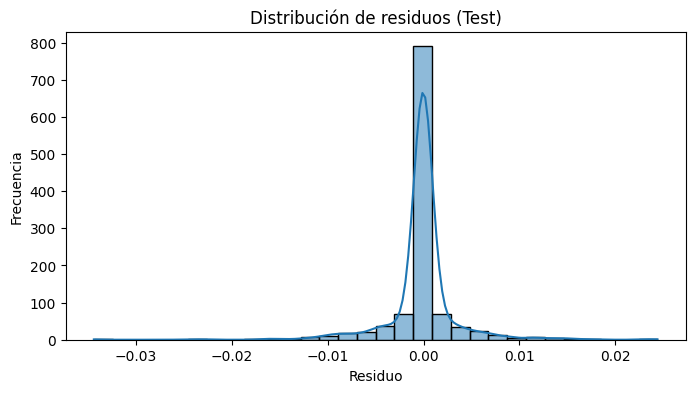

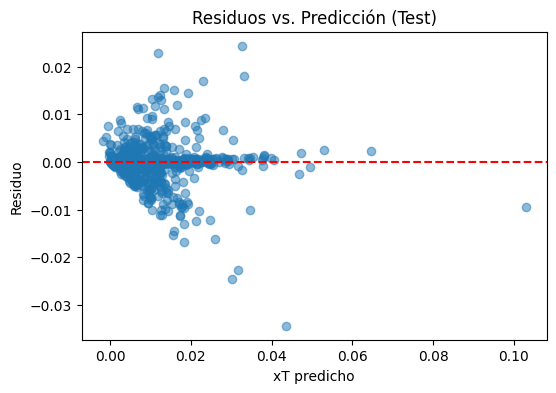

In [29]:

y_pred_test = best_pipe.predict(X_test)


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("xT real")
plt.ylabel("xT predicho")
plt.title("Ridge: xT real vs. predicho (Test)")
plt.show()


residuos = y_test - y_pred_test
plt.figure(figsize=(8,4))
sns.histplot(residuos, bins=30, kde=True)
plt.title("Distribución de residuos (Test)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()


plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("xT predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs. Predicción (Test)")
plt.show()


# Estabilidad del modelo con validación cruzada
Para poder evaluar la robustez del modelo Ridge (α=1) y su capacidad de generalización, hemos realizado una validación cruzada utilizando GroupKFold con 5 splits, asegurando que todas las posesiones de un mismo partido estén en el mismo fold.

**Resultados de la validación cruzada:**
- CV R2 (media ± std): 0.8013 ± 0.0218
- Esto significa que el modelo tiene una buena capacidad predictiva y es estable, ya que la desviación estándar es baja (0.0218), indicando que el rendimiento del modelo no varía mucho entre los diferentes folds (partidos).

**Interpretacion:**
- Cada barra representa el valor de R² obtenido en cada fold (partido) durante la validación cruzada.
- Los valores se mantienen estables alrededor de la media (0.8013), lo que sugiere que el modelo no está sobreajustando a ningún partido en particular y generaliza bien a diferentes conjuntos de datos (contexto de partidos distintos).

**Conclusión**
- El modelo Ridge muestra un rendimeinto sólido y estable en la validación cruzada con GroupKFold. Por lo que se puede confiar en su capacidad para predecir el KPI 'xt_Medio_last' en posesiones que comienzan en el tercio defensivo y terminan en el tercio medio, incluso en partidos no vistos previamente.

CV R2 (media ± std): 0.8013 ± 0.0218


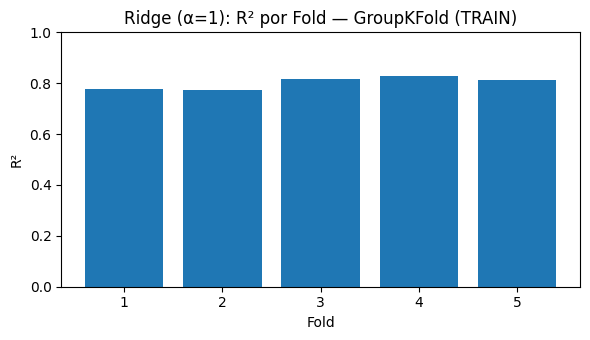

In [ ]:
cv = GroupKFold(n_splits=5)
cv_scores = cross_val_score(best_pipe, X_train, y_train, groups=groups_train,
                            cv=cv, scoring='r2', n_jobs=2)

print(f"CV R2 (media ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
plt.figure(figsize=(6,3.5))
plt.bar(range(1, len(cv_scores)+1), cv_scores)
plt.ylim(0, 1)
plt.xlabel("Fold")
plt.ylabel("R²")
plt.title("Ridge (α=1): R² por Fold — GroupKFold (TRAIN)")
plt.tight_layout()
plt.show()


In [34]:
# Top-K errores (para casos de estudio):
import pandas as pd

err_abs = np.abs(residuos)
top_k = 50
idx = np.argsort(-err_abs)[:top_k]
pd.DataFrame({
    "y_real": y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx],
    "y_pred": y_pred_test[idx],
    "residuo": residuos.iloc[idx] if hasattr(residuos, "iloc") else residuos[idx],
})


,y_real,y_pred,residuo
0,0.0093,0.043685,-0.034385
1,0.0057,0.030228,-0.024528
2,0.0571,0.032712,0.024388
3,0.0348,0.011843,0.022957
4,0.0089,0.031602,-0.022702
5,0.0512,0.033213,0.017987
6,0.0399,0.022925,0.016975
7,0.0016,0.018356,-0.016756
8,0.0096,0.025865,-0.016265
9,0.0288,0.013376,0.015424


In [35]:
# Top-K aciertos (menores errores absolutos)
top_k = 50
err_abs = np.abs(residuos)

# índices de los K con menor error
idx_best = np.argsort(err_abs)[:top_k]

pd.DataFrame({
    "y_real": y_test.iloc[idx_best] if hasattr(y_test, "iloc") else y_test[idx_best],
    "y_pred": y_pred_test[idx_best],
    "residuo": residuos.iloc[idx_best] if hasattr(residuos, "iloc") else residuos[idx_best],
})


,y_real,y_pred,residuo
0,0.0086,0.008600,4.442409e-07
1,0.0068,0.006799,6.440096e-07
2,0.0248,0.024798,1.551583e-06
3,0.0013,0.001302,-1.814798e-06
4,0.0067,0.006702,-2.351590e-06
5,0.0061,0.006097,3.065914e-06
6,0.0053,0.005296,4.095025e-06
7,0.0056,0.005605,-4.568137e-06
8,0.0033,0.003295,4.864298e-06
9,0.0096,0.009605,-4.909001e-06


## Conclusiones generales
- La metodología CRISP-DM ha sido efectiva para guiar el análisis y modelado de los datos de posesiones de fútbol.
- En el primer experimento, la validación con KFold aleatorio no fue adecuada debido a la fuga de datos entre entrenamiento y validación.
- El segundo experimento con GroupKFold proporcionó una evaluación más realista y fiable del rendimiento del modelo.
- El modelo Ridge (α=1)es un modelo robusto, interpretable y con buena capacidad predictiva.
- Las gráficas sobre test muestran un buen ajuste sobre los datos no vistos, con errores bajos y distribuidos aleatoriamente. (Esto es normal en deportes como el fútbol donde hay un alto grado de impredecibilidad debido a la naturaleza dinámica del juego y la influencia de factores humanos que pueden afectar el rendimiento y no se pueden modelar fácilmente).